In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new/")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow_probability.substrates import jax as tfp

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# TriplePandelSPE/JAX stuff
from lib.simdata_i3 import I3SimHandler
from lib.geo import center_track_pos_and_time_based_on_data
from lib.smaller_network_eqx import get_network_eval_v_fn
from dom_track_eval import get_eval_network_doms_and_track
from likelihood_conv_mpe_w_noise import get_neg_c_triple_gamma_llh

import optax
import blackjax

import time

In [2]:
# Event Index.
event_index = 2
# Get network and eval logic.
dtype = jnp.float64
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco_new/data/smaller_network_eqx/tpn_smallest_default_tree_start_epoch_192', dtype=jnp.float64)
#eval_network_v = get_network_eval_v_fn(bpath="/home/storage/hans/photondata/train_in_jax/cache_z_and_dist_penalty/w_z_and_dist_penalty_tpn_smallest_default_tree_start_epoch_190.eqx", dtype=jnp.float64)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=jnp.float64)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'

#sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'),
#                              os.path.join(bp, 'pulses_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'),
#                              '/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')

sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

muon energy: 4.7 TeV


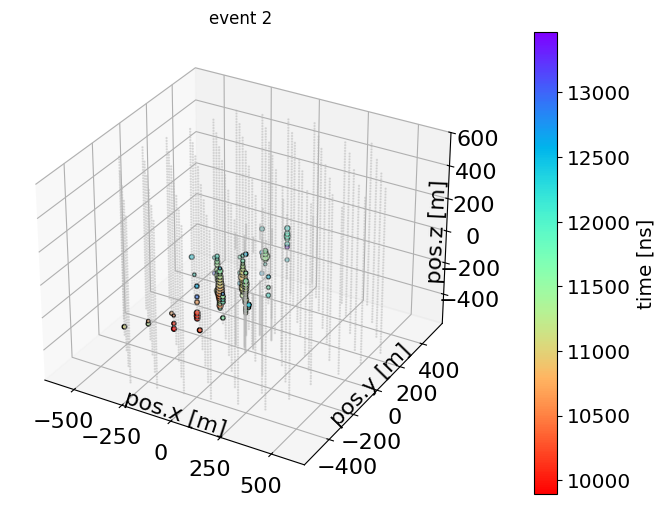

In [3]:
            # Plot event.
            fig = plt.figure(figsize=(8,6))
            ax = plt.subplot(projection='3d')
            ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
            ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
            ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)
            ax.set_title(f'event {event_index}')

            df = event_data
            idx = df['charge'] > 0
            geo = sim_handler.geo

            try:
                im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.5, c='0.7', alpha=0.4)
            except:
                pass

            im = ax.scatter(df[idx]['x'], df[idx]['y'], df[idx]['z'], s=np.sqrt(df[idx]['charge']*100), c=df[idx]['time'],
                            cmap='rainbow_r',  edgecolors='k', zorder=1000)
            ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
            cb = plt.colorbar(im, orientation="vertical", pad=0.1)
            cb.set_label(label='time [ns]', size='x-large')
            cb.ax.tick_params(labelsize='x-large')
            plt.show()

In [4]:
# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("shifted seed vertex:", centered_track_pos)

original seed vertex: [ -777.15166078 -1656.22843231 -1472.45624098]
shifted seed vertex: [-164.52122541  320.02418746 -330.17880541]


In [5]:
print(np.rad2deg(track_src))

[118.90235164 252.77677215]


In [6]:
print(centered_track_pos)

[-164.52122541  320.02418746 -330.17880541]


In [7]:
# Clip charge and combine into single data tensor for fitting.
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time', 'charge']].to_numpy())
print(fitting_event_data.shape)

# Setup likelihood
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)
print(neg_llh(track_src, centered_track_pos, centered_track_time, fitting_event_data))

(102, 5)
1325.2765543202506


In [8]:
scale = 20.0
scale_rad = 30.0

@jax.jit
def log_p(x):
        # project back if outside of [0, pi] x [0, 2*pi]
        zenith = x[0] / scale_rad
        azimuth = x[1] / scale_rad
        zenith = jnp.fmod(zenith, 2.0*jnp.pi)
        zenith = jnp.where(zenith < 0, zenith+2.0*jnp.pi, zenith)
        cond = zenith > jnp.pi
        zenith = jnp.where(cond, -1.0*zenith+2.0*jnp.pi, zenith)
        azimuth = jnp.where(cond, azimuth-jnp.pi, azimuth)

        azimuth = jnp.fmod(azimuth, 2.0*jnp.pi)
        azimuth = jnp.where(azimuth < 0, azimuth+2.0*jnp.pi, azimuth)

        projected_dir = jnp.array([zenith, azimuth])
        return -0.5*neg_llh(projected_dir, x[2:]*scale, centered_track_time, fitting_event_data)

In [9]:
n_chains = 100

rng_key = jax.random.key(0)

warmup = blackjax.chees_adaptation(log_p, n_chains)
key_warmup, key_sample = jax.random.split(rng_key)
optim = optax.adam(learning_rate=0.01)

#track_src_init = jnp.deg2rad(jnp.array([131.5, 218]))
track_src_init = track_src

track_pos_init = centered_track_pos + 30.0
#track_pos_init = centered_track_pos

x0 = jnp.concatenate([track_src_init*scale_rad, track_pos_init/scale])
x0 = jnp.repeat(jnp.expand_dims(x0, axis=0), n_chains, axis=0)

initial_step_size = 0.2
num_warmup_steps = 1000


start = time.time()

(last_states, parameters), warmup_samples = warmup.run(
    key_warmup,
    x0,
    initial_step_size,
    optim,
    num_warmup_steps,
)

print(last_states[0].shape)
end = time.time()

print(end-start)

(100, 5)
128.09982347488403


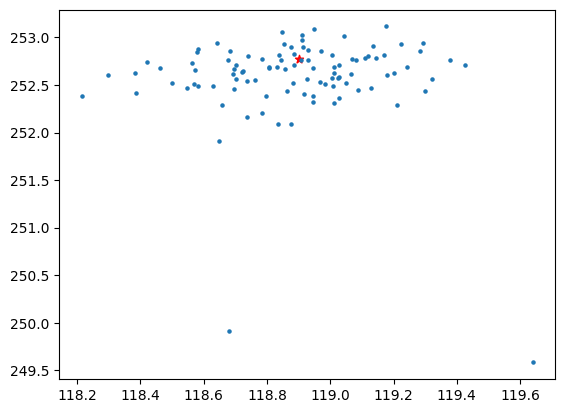

In [10]:
plt.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red')
x = np.rad2deg(last_states[0][:, :2] / scale_rad)
plt.scatter(x[:,0], x[:,1], s=5)

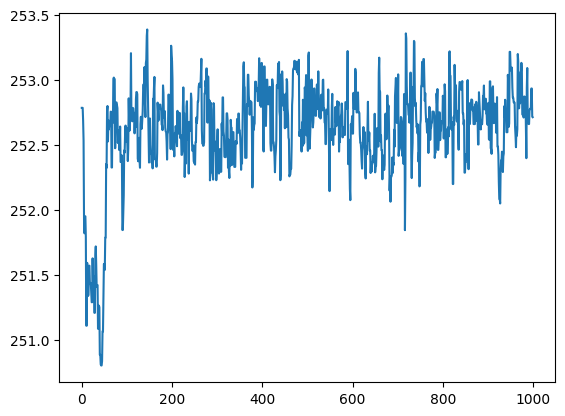

In [11]:
plt.plot(np.arange(num_warmup_steps), np.rad2deg(warmup_samples[0].position[:, 0, 1] / scale_rad))

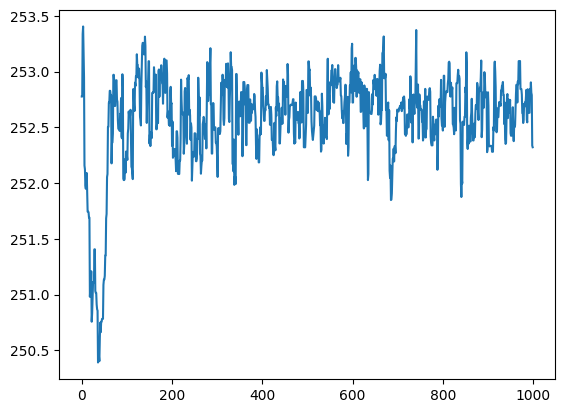

In [12]:
plt.plot(np.arange(num_warmup_steps), np.rad2deg(warmup_samples[0].position[:, 1, 1] / scale_rad))

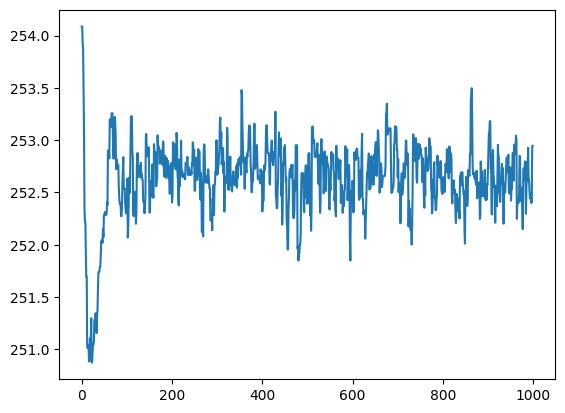

In [13]:
plt.plot(np.arange(num_warmup_steps), np.rad2deg(warmup_samples[0].position[:, 2, 1] / scale_rad))

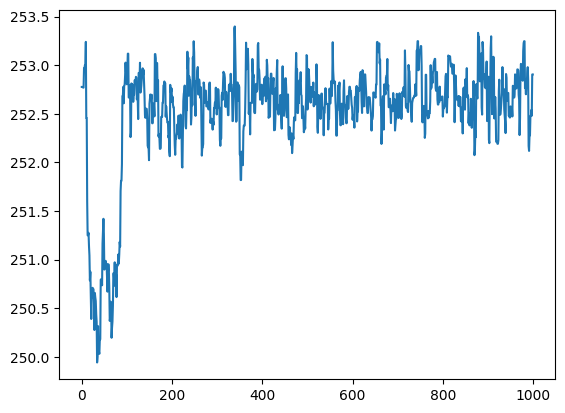

In [14]:
plt.plot(np.arange(num_warmup_steps), np.rad2deg(warmup_samples[0].position[:, 3, 1] / scale_rad))

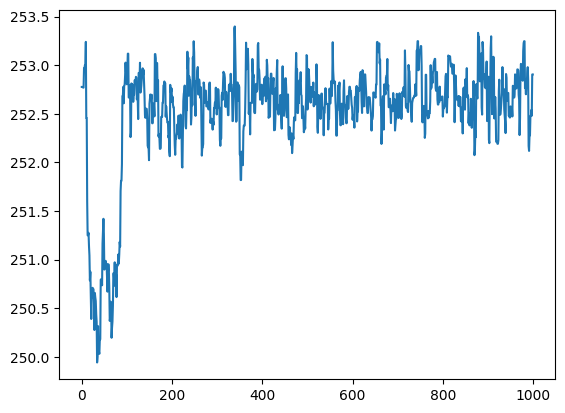

In [15]:
plt.plot(np.arange(num_warmup_steps), np.rad2deg(warmup_samples[0].position[:, 3, 1] / scale_rad))


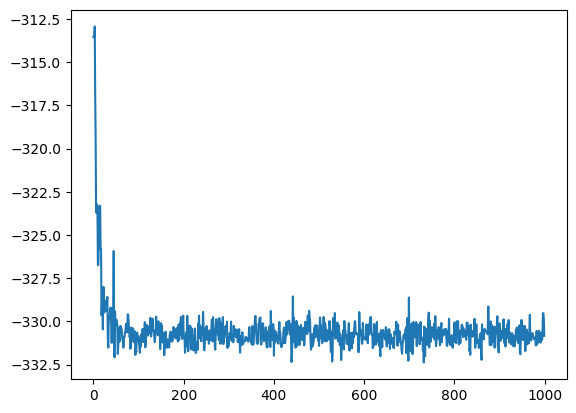

In [16]:
plt.plot(np.arange(num_warmup_steps), warmup_samples[0].position[:, 0, 4] * scale)

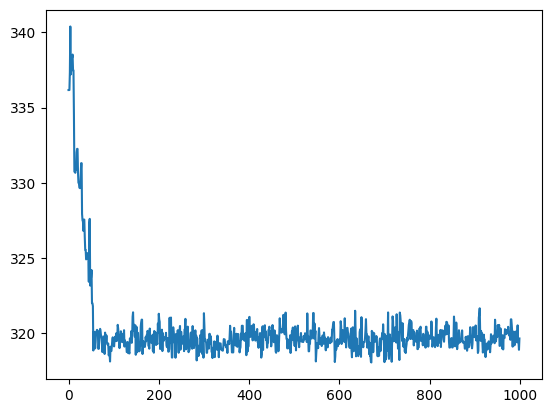

In [17]:
plt.plot(np.arange(num_warmup_steps), warmup_samples[0].position[:, 0, 3] * scale)

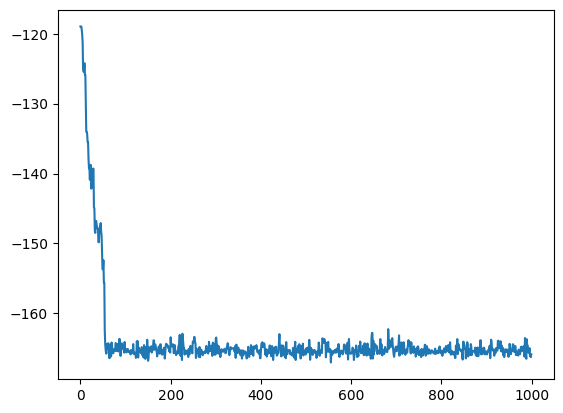

In [18]:
plt.plot(np.arange(num_warmup_steps), warmup_samples[0].position[:, 0, 2] * scale)

In [19]:
kernel = blackjax.dynamic_hmc(log_p, **parameters).step
#new_states, info = jax.vmap(kernel)(chain_keys, last_states)

In [20]:
def inference_loop_multiple_chains(
    rng_key, kernel, initial_state, num_samples, num_chains
):

    @jax.jit
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [21]:
import time

start = time.time()

states = inference_loop_multiple_chains(
    key_sample, kernel, last_states, 100, n_chains
)

print(states.position[:, :, :2].shape)

end = time.time()

print(end - start)

(100, 100, 2)
14.269574880599976


In [22]:
states.position.shape

(100, 100, 5)

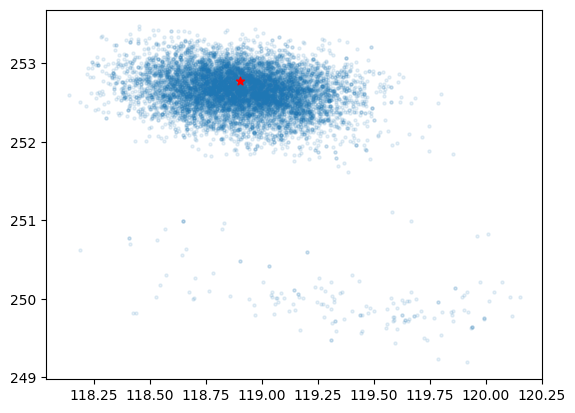

In [23]:
x = np.rad2deg(states.position[:, :, :2] / scale_rad)
plt.scatter(x[:, :, 0], x[:, : ,1], s=5, alpha = 0.1)
plt.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red')

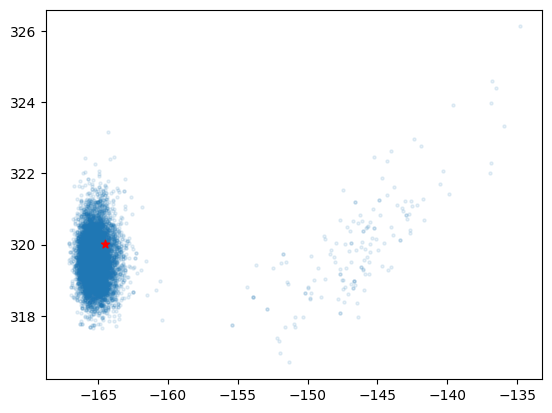

In [24]:
x = states.position[:, :, 2:] * scale
plt.scatter(x[:, :, 0], x[:, : ,1], s=5, alpha = 0.1)
plt.scatter(centered_track_pos[0], centered_track_pos[1], marker="*", color='red')

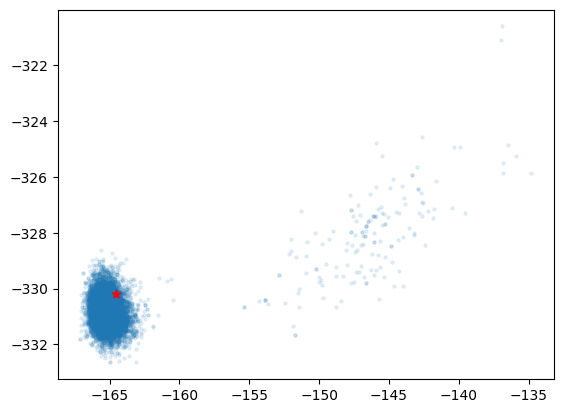

In [25]:
x = states.position[:, :, 2:] * scale
plt.scatter(x[:, :, 0], x[:, : ,2], s=5, alpha = 0.1)
plt.scatter(centered_track_pos[0], centered_track_pos[2], marker="*", color='red')

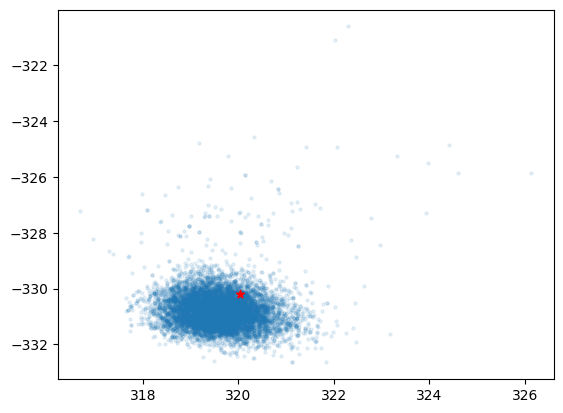

In [26]:
x = states.position[:, :, 2:] * scale
plt.scatter(x[:, :, 1], x[:, : ,2], s=5, alpha = 0.1)
plt.scatter(centered_track_pos[1], centered_track_pos[2], marker="*", color='red')

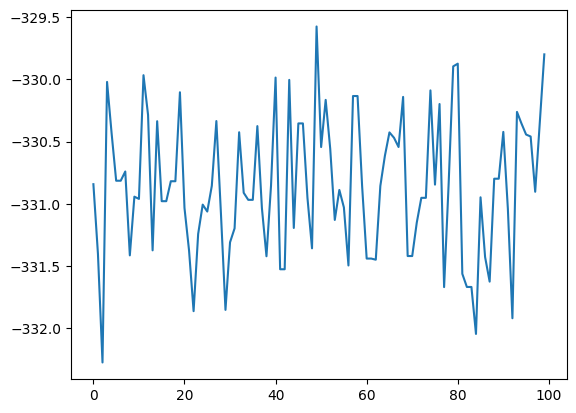

In [27]:
plt.plot(np.arange(100), states.position[:, 0, 4] * scale)

In [28]:
from jax.scipy.stats import gaussian_kde
x = np.rad2deg(states.position[:, :, :2] / scale_rad)

In [29]:
x = x.reshape((x.shape[0]*x.shape[1], 2)).T

In [30]:
kde = gaussian_kde(x, 0.3)

In [31]:
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=True, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

In [32]:
dzen = 0.02
dazi = 0.02
n_eval = 500

zenith = jnp.linspace(track_src[0]-dzen, track_src[0]+dazi, n_eval)
azimuth = jnp.linspace(track_src[1]-dzen, track_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(jnp.rad2deg(zenith), jnp.rad2deg(azimuth))

In [33]:
x = jnp.concatenate([jnp.expand_dims(X.flatten(), axis=0), jnp.expand_dims(Y.flatten(), axis=0)], axis=0)

In [34]:
z = kde.evaluate(x)

In [35]:
z = z.reshape(X.shape)

In [36]:
track_src

Array([2.07523752, 4.41178695], dtype=float64)

In [37]:
X.shape

(500, 500)

In [38]:
x = np.rad2deg(states.position[:, :, :2] / scale_rad)
x = x.reshape((x.shape[0]*x.shape[1], 2))

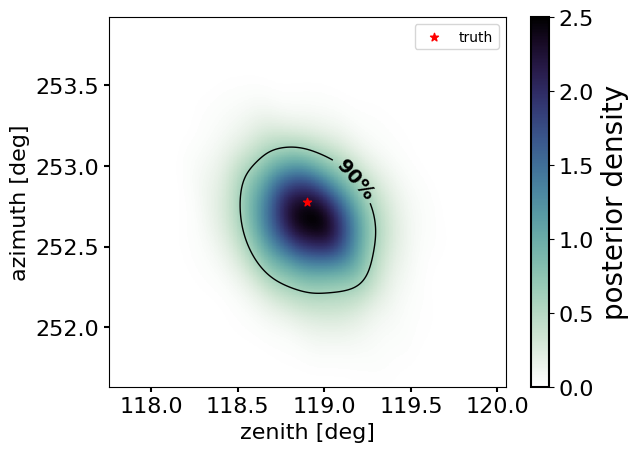

In [58]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(X, Y, z, vmin=0, vmax=2.5, shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("posterior density", fontsize=20)
cbar.outline.set_linewidth(1.5)

#ax.scatter(x[:, 0], x[:, 1], s=2, alpha=0.05)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)
ct = plt.contour(X, Y, z, levels=[0.6], linestyles=['solid'], colors=['black'], linewidths=1.0)
labels=['$\\mathbf{90\\%}$']
fmt={}
for l,s in zip( ct.levels, labels ):
        fmt[l] = s
plt.clabel(ct, ct.levels, inline=1, fontsize=14, fmt=fmt, colors=['black'])

plt.legend()
plt.show()

In [40]:
z

Array([[1.92542156e-20, 2.46162398e-20, 3.13293495e-20, ...,
        4.59486797e-05, 3.96983230e-05, 3.41456197e-05],
       [1.49751428e-20, 1.91297240e-20, 2.43265397e-20, ...,
        4.76203020e-05, 4.11087994e-05, 3.53297812e-05],
       [1.16295607e-20, 1.48437259e-20, 1.88606468e-20, ...,
        4.92786503e-05, 4.25054808e-05, 3.65001263e-05],
       ...,
       [3.87869209e-16, 5.87345661e-16, 8.85431982e-16, ...,
        6.14671014e-32, 3.12804787e-32, 1.58466190e-32],
       [3.52525250e-16, 5.33398409e-16, 8.03462483e-16, ...,
        4.40498552e-32, 2.23983720e-32, 1.13375960e-32],
       [3.19929949e-16, 4.83691827e-16, 7.28005194e-16, ...,
        3.15205198e-32, 1.60142520e-32, 8.09939341e-33]], dtype=float64)

In [41]:
X

Array([[117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       ...,
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723]], dtype=float64)

In [42]:
X

Array([[117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       ...,
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723]], dtype=float64)

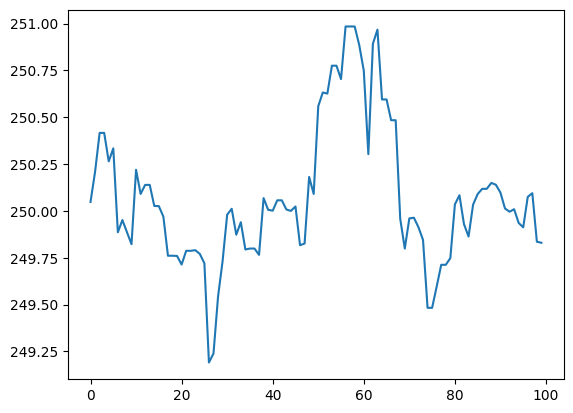

In [43]:
plt.plot(np.arange(100), jnp.rad2deg(states.position[:, 73, 1] / scale_rad))

In [44]:
kde_vals = kde(x.T)

In [45]:
kde_vals_sorted = kde_vals.copy()

In [46]:
kde_vals_sorted.sort()
kde_vals_sorted = kde_vals_sorted[::-1]
n_total = len(kde_vals_sorted)

In [47]:
fracs = np.zeros_like(kde_vals_sorted)

In [48]:
for i, val in enumerate(kde_vals_sorted):
    fracs[i] = i / float(n_total)

In [49]:
kde_vals_sorted

Array([0.3730345 , 1.09390915, 1.08181707, ..., 0.24884437, 1.41989808,
       2.42007421], dtype=float64)

In [50]:
idx = np.searchsorted(fracs, 0.9, side='left', sorter=None)

In [51]:
print(idx, fracs[idx], kde_vals_sorted[idx])

9000 0.9 0.6130518848247763


In [52]:
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm
import matplotlib
from matplotlib import ticker

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    vmin=vals.min()
    vmax=vals.max() 
    cmap = plt.get_cmap("cubehelix", 20)
    norm = Normalize( vmin=vmin, vmax=vmax )
   
    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap=cmap).to_rgba( val ) for val in vals]
    cbar_probs = [norm, cmap, vmin, vmax]

    return colours, cbar_probs

colours, cbar_probs = makeColours( kde_vals )


In [53]:
x.shape

(10000, 2)

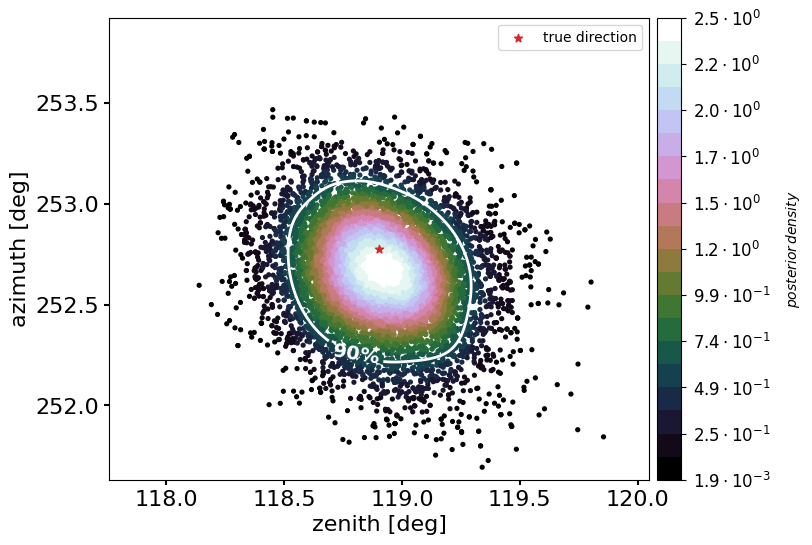

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# sub sample
plt.scatter(x[:, 0], x[:,1 ], marker=".", color=colours, s=30, )
ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='tab:red', label="true direction", zorder=200)
ct = plt.contour(X, Y, z, levels=[0.6130518848247763], linestyles=['solid'], colors=['white'], linewidths=2.0)
labels=['$\\mathbf{90\\%}$']
fmt={}
for l,s in zip( ct.levels, labels ):
        fmt[l] = s
plt.clabel(ct, ct.levels, inline=1, fontsize=14, fmt=fmt, colors=['white'])

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

#ax.yaxis.set_label_coords(-0.15, 1.)
#ax.xaxis.set_label_coords(1.0, -0.12)
ax.legend()

def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${}\cdot 10^{{{}}}$'.format(a, b)


fig.subplots_adjust(right=0.8)
cbar_ax1 = fig.add_axes([0.81, 0.11, 0.03, 0.77])
cbar = mpl.colorbar.ColorbarBase(cbar_ax1, format=ticker.FuncFormatter(fmt), spacing='uniform', 
                                 ticks=np.linspace(cbar_probs[2], cbar_probs[3],11), 
                                 cmap=cbar_probs[1], 
                                 norm=cbar_probs[0], 
                                 orientation='vertical')

cbar.set_label('$posterior\,density$', labelpad=10)
cbar.ax.tick_params(labelsize=12, pad=5)
cbar.update_ticks()

plt.show()